In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [4]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [5]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [8]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [9]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))
"""
y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))\ny_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))\n\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [10]:
logdir = "logs/Frequency/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [11]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [12]:
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [15]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - R2Score: 0.5693 - loss: 0.4135 - val_R2Score: 0.8764 - val_loss: 0.1189
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - R2Score: 0.8671 - loss: 0.1480 - val_R2Score: 0.9172 - val_loss: 0.0797
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - R2Score: 0.9067 - loss: 0.0909 - val_R2Score: 0.9227 - val_loss: 0.0744
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9210 - loss: 0.0816 - val_R2Score: 0.9347 - val_loss: 0.0628
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9292 - loss: 0.0793 - val_R2Score: 0.9534 - val_loss: 0.0448
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.9371 - loss: 0.0630 - val_R2Score: 0.9514 - val_loss: 0.0468
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.9392 - loss: 0.0603 - val_R2Score: 0.9565 - val_loss: 0.0418
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - R2Score: 0.9452 - loss: 0.0531 - val_R2Score: 0.9585 -

In [16]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - R2Score: 0.9924 - loss: 0.0082
Test accuracy: 0.9920923113822937


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

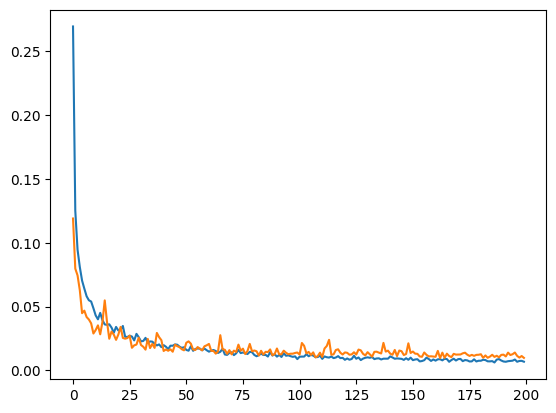

In [18]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [19]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [20]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
              0
0     19.754179
1      4.211177
2      9.490793
3      3.540447
4      4.470150
...         ...
2452  20.388758
2453  30.719301
2454  17.404850
2455  21.462259
2456   3.881695

[2457 rows x 1 columns]


In [21]:
y_test["frequency"]

524      20.6428
10325     3.6637
11646     9.2175
10238     3.2967
10214     4.2590
          ...   
11507    20.6383
2709     30.6522
12218    17.6490
2858     21.5420
9935      3.6527
Name: frequency, Length: 2457, dtype: float64

In [22]:
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

2.921585406624729

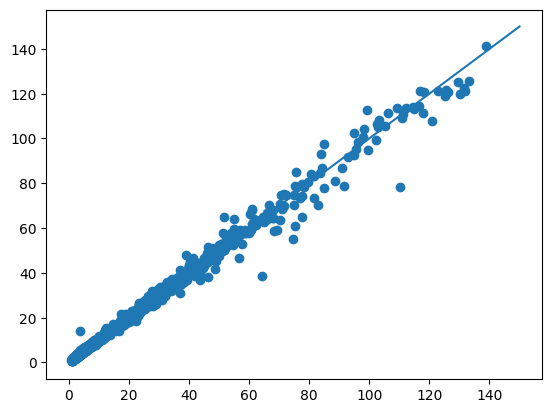

In [24]:
pred=predictions_df
ansys=y_test["frequency"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.show()

In [26]:
clear_session()
del model
gc.collect()

0

In [27]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  2.1 MiB
                             x:  1.6 MiB
                       x_train:  1.4 MiB
           x_train_transformed:  1.0 MiB
                             y: 480.0 KiB
                       y_train: 460.7 KiB
                        x_test: 356.4 KiB
            x_test_transformed: 268.9 KiB
                        y_test: 115.2 KiB
 y_train_transformed_frequency: 76.9 KiB
